# Telecom Churn Prediction - Classification

In [ ]:
!pip install --pre pycaret

In [ ]:
!pip install shap

In [3]:
# to access the data on google drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
from pycaret.classification import *

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy import stats

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, recall_score, f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("talk")

# Telcom Churn Prediction

Which customers are likely to churn? What are the attributes that make you think so?

The features:
  - customerID - customer id
  - gender - client gender (male / female)
  - SeniorCitizen - is the client retired (1, 0)
  - Partner - is the client married (Yes, No)
  - tenure - how many months a person has been a client of the company
  - PhoneService - is the telephone service connected (Yes, No)
  - MultipleLines - are multiple phone lines connected (Yes, No, No phone service)
  - InternetService - client’s Internet service provider (DSL, Fiber optic, No)
  - OnlineSecurity - is the online security service connected (Yes, No, No internet service)
  - OnlineBackup - is the online backup service activated (Yes, No, No internet service)
  - DeviceProtection - does the client have equipment insurance (Yes, No, No internet service)
  - TechSupport - is the technical support service connected (Yes, No, No internet service)
  - StreamingTV - is the streaming TV service connected (Yes, No, No internet service)
  - StreamingMovies - is the streaming cinema service activated (Yes, No, No internet service)
  - Contract - type of customer contract (Month-to-month, One year, Two year)
  - PaperlessBilling - whether the client uses paperless billing (Yes, No)
  - PaymentMethod - payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
  - MonthlyCharges - current monthly payment
  - TotalCharges - the total amount that the client paid for the services for the entire time
  - Churn - whether there was a churn: customers who left within the last month (Yes or No)

In [3]:
df_telco = pd.read_csv("/content/drive/MyDrive/propulsion/Machine_Learning/data/telecom_users.csv")
df = df_telco.drop(["Unnamed: 0", "customerID"], axis=1).copy()
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,Female,0,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,Male,0,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
4,Male,0,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No


In [4]:
# replace TotalCharges that are blank with NaN
df["TotalCharges"] = df["TotalCharges"].replace(" ", np.nan)

# convert total charges to integer
df["TotalCharges"] = df["TotalCharges"].astype(float)

In [5]:
# convert yes/no, female/male, type of internet service to 1/0
df_clean = df.replace({"No": 0, "No internet service": 0, "No phone service": 0, "Male": 0, "Yes": 1, "Female": 1, "DSL": 1, "Fiber optic": 1})
# group the payment type into automatic and other
df_clean["AutoPayment"] = np.where(df_clean["PaymentMethod"].str.contains("automatic"), 1, 0)
df_clean = df_clean.drop(columns=["PaymentMethod"])
# rename the variables
df_clean = df_clean.rename(columns={"gender": "Female", "Partner": "Married"})

In [6]:
# create dummy variables from the remaining categorical variables
df_num = pd.get_dummies(df_clean)

# drop missing and scale the MonthlyCharges and tenure variables to (0,1) range
df_num = df_num.dropna()
scaler = MinMaxScaler()
df_num[["MonthlyCharges_sc"]] = scaler.fit_transform(df_num[["MonthlyCharges"]])
df_num[["Tenure_sc"]] = scaler.fit_transform(df_num[["tenure"]])

# drop the variables that are not included in the model
df_caret = df_num.drop(columns=["Contract_One year", "InternetService", "tenure", "TotalCharges", "MonthlyCharges"])

In [7]:
df_caret.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5976 entries, 0 to 5985
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Female                   5976 non-null   int64  
 1   SeniorCitizen            5976 non-null   int64  
 2   Married                  5976 non-null   int64  
 3   Dependents               5976 non-null   int64  
 4   PhoneService             5976 non-null   int64  
 5   MultipleLines            5976 non-null   int64  
 6   OnlineSecurity           5976 non-null   int64  
 7   OnlineBackup             5976 non-null   int64  
 8   DeviceProtection         5976 non-null   int64  
 9   TechSupport              5976 non-null   int64  
 10  StreamingTV              5976 non-null   int64  
 11  StreamingMovies          5976 non-null   int64  
 12  PaperlessBilling         5976 non-null   int64  
 13  Churn                    5976 non-null   int64  
 14  AutoPayment             

In [8]:
df_caret.head()

,Female,SeniorCitizen,Married,Dependents,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,Churn,AutoPayment,Contract_Month-to-month,Contract_Two year,MonthlyCharges_sc,Tenure_sc
0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,1,0,1,0.058209,1.000000
1,1,0,0,0,1,0,0,1,1,0,1,0,1,0,1,1,0,0.695522,0.605634
2,1,1,1,0,1,1,0,0,0,0,0,0,1,1,1,1,0,0.564179,0.521127
3,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0.374627,0.042254
4,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0.350249,0.014085


# <font color="blue"> PyCaret </font>

In [9]:
clf = setup(data=df_caret, 
            target="Churn", 
            session_id=18, # similar to random_state
            fix_imbalance=True,
            fix_imbalance_method="RandomOverSampler",
            normalize=True,
            experiment_name='telcochurn',
            n_jobs=-1)

,Description,Value
0,Session id,18
1,Target,Churn
2,Target type,Binary
3,Original data shape,"(5976, 19)"
4,Transformed data shape,"(7937, 19)"
5,Transformed train set shape,"(6144, 19)"
6,Transformed test set shape,"(1793, 19)"
7,Numeric features,18
8,Preprocess,True
9,Imputation type,simple


In [10]:
best_model = compare_models(fold=5, sort="Recall")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.6785,0.8104,0.8470,0.4447,0.5831,0.3604,0.4105,0.1000
qda,Quadratic Discriminant Analysis,0.7236,0.8236,0.8056,0.4877,0.6075,0.4134,0.4447,0.0640
ridge,Ridge Classifier,0.7344,0.0000,0.8020,0.4999,0.6159,0.4291,0.4572,0.0460
ada,Ada Boost Classifier,0.7442,0.8373,0.8020,0.5119,0.6249,0.4449,0.4707,0.2640
lda,Linear Discriminant Analysis,0.7346,0.8357,0.8020,0.5002,0.6161,0.4295,0.4576,0.0700
lr,Logistic Regression,0.7413,0.8361,0.8002,0.5082,0.6216,0.4395,0.4658,1.4640
gbc,Gradient Boosting Classifier,0.7430,0.8376,0.7777,0.5107,0.6164,0.4354,0.4574,0.5000
svm,SVM - Linear Kernel,0.7294,0.0000,0.7516,0.4981,0.5973,0.4073,0.4282,0.0760
knn,K Neighbors Classifier,0.6797,0.7357,0.7021,0.4361,0.5379,0.3127,0.3336,0.5280
lightgbm,Light Gradient Boosting Machine,0.7614,0.8247,0.6832,0.5401,0.6031,0.4358,0.4422,0.2860


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

In [11]:
nb = create_model("nb", fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6858,0.8315,0.8919,0.4531,0.6009,0.3843,0.4448
1,0.6834,0.8017,0.8468,0.4487,0.5866,0.3671,0.4161
2,0.6726,0.8108,0.8386,0.4400,0.5772,0.3500,0.3988
3,0.6675,0.8160,0.8514,0.4355,0.5762,0.3467,0.3998
4,0.6830,0.7918,0.8063,0.4464,0.5746,0.3537,0.3931
Mean,0.6785,0.8104,0.8470,0.4447,0.5831,0.3604,0.4105
Std,0.0071,0.0134,0.0274,0.0063,0.0098,0.0139,0.0188


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

# <font color="blue"> Individual models </font>

Split the data into train and test

In [12]:
X = df_caret.drop(columns=["Churn"])
y = df_caret["Churn"]

In [13]:
X_train_imb, X_test, y_train_imb, y_test = train_test_split(X, y, test_size=0.2, random_state=18, stratify=y)

In [14]:
# fit and apply the transformation to correct for the imbalance in churn
X_train, y_train = SMOTE().fit_resample(X_train_imb, y_train_imb)

Create lists for storing the model name and results

In [15]:
list_mod = []
list_f1 = []
list_recall = []


## Train and Evaluate Logistic Regression



In [16]:
logreg = LogisticRegression(random_state=18, solver="liblinear")

list_mod.append("Logistic Regression")
list_f1.append(np.mean(cross_val_score(logreg, X_train, y_train, scoring="f1", cv=5)))
list_recall.append(np.mean(cross_val_score(logreg, X_train, y_train, scoring="recall", cv=5)))


## Train and Evaluate Naive Bayes


In [17]:
nb = BernoulliNB()

list_mod.append("Naive Bayes")
list_f1.append(np.mean(cross_val_score(nb, X_train, y_train, scoring="f1", cv=5)))
list_recall.append(np.mean(cross_val_score(nb, X_train, y_train, scoring="recall", cv=5)))

## Train and Evaluate SVM

In [18]:
svc = SVC(random_state=18, max_iter=10000)

list_mod.append("Support Vector Classification")
list_f1.append(np.mean(cross_val_score(svc, X_train, y_train, scoring="f1", cv=5)))
list_recall.append(np.mean(cross_val_score(svc, X_train, y_train, scoring="recall", cv=5)))

## Train and Evaluate Decision Tree


In [19]:
dtree = DecisionTreeClassifier(random_state=18)

list_mod.append("Decision Tree")
list_f1.append(np.mean(cross_val_score(dtree, X_train, y_train, scoring="f1", cv=5)))
list_recall.append(np.mean(cross_val_score(dtree, X_train, y_train, scoring="recall", cv=5)))

## Train and Evaluate Random Forest


In [20]:
rf = RandomForestClassifier(random_state=18)

list_mod.append("Random Forest")
list_f1.append(np.mean(cross_val_score(rf, X_train, y_train, scoring="f1", cv=5)))
list_recall.append(np.mean(cross_val_score(rf, X_train, y_train, scoring="recall", cv=5)))

## Train and Evaluate AdaBoost


In [21]:
ada_boost = AdaBoostClassifier(random_state=18)

list_mod.append("Adaptive Boosting")
list_f1.append(np.mean(cross_val_score(ada_boost, X_train, y_train, scoring="f1", cv=5)))
list_recall.append(np.mean(cross_val_score(ada_boost, X_train, y_train, scoring="recall", cv=5)))

## Train and Evaluate Gradient Boosting

In [22]:
gbm = GradientBoostingClassifier(random_state=18)

list_mod.append("Gradient Boosting")
list_f1.append(np.mean(cross_val_score(gbm, X_train, y_train, scoring="f1", cv=5)))
list_recall.append(np.mean(cross_val_score(gbm, X_train, y_train, scoring="recall", cv=5)))

## Train and Evaluate Extreme Gradient Boosting (XGBoost)


In [23]:
xgb = XGBClassifier(random_state=18)

list_mod.append("Extreme Gradient Boosting")
list_f1.append(np.mean(cross_val_score(xgb, X_train, y_train, scoring="f1", cv=5)))
list_recall.append(np.mean(cross_val_score(xgb, X_train, y_train, scoring="recall", cv=5)))

In [24]:
results_base = pd.DataFrame({
    "Model": list_mod,
    "F1 Score": list_f1,
    "Recall Score": list_recall
}).sort_values(by=["Recall Score"], ascending=False)

results_base

,Model,F1 Score,Recall Score
4,Random Forest,0.841623,0.870716
7,Extreme Gradient Boosting,0.807982,0.848779
6,Gradient Boosting,0.806292,0.840520
2,Support Vector Classification,0.803249,0.837103
5,Adaptive Boosting,0.795879,0.836250
1,Naive Bayes,0.753545,0.810887
0,Logistic Regression,0.785940,0.810611
3,Decision Tree,0.764105,0.767328


# Model Selection

  - Based on the business need, the most important aspect is to correctly predict the potential churn candidate (i.e., the true positive). Therefore, we select the model with the highest Recall Score.
  - From the models above, the one with the highest Recall Score is Random Forest (RF).

# Model Interpretation using SHAP

Interpret the results from the models built before to predict churn.


In [25]:
raf = RandomForestClassifier(random_state=18)
raf.fit(X_train, y_train)

explainer_raf = shap.TreeExplainer(raf)
shap_values_raf = explainer_raf.shap_values(X_test)

shap_values_raf = shap_values_raf[1]
pd.DataFrame(shap_values_raf, columns=X_test.columns).head(3)

,Female,SeniorCitizen,Married,Dependents,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,AutoPayment,Contract_Month-to-month,Contract_Two year,MonthlyCharges_sc,Tenure_sc
0,-0.001951,-0.000489,-0.008918,-0.017678,-0.001323,0.004392,-0.061703,-0.025637,0.000111,-0.033480,-0.005365,-0.007130,-0.004394,-0.035111,-0.095771,-0.106234,0.065833,-0.124989
1,-0.000046,-0.011731,-0.014929,-0.042091,-0.003088,0.014819,-0.133105,-0.029074,-0.005438,0.025643,-0.013345,-0.003969,0.000257,0.006247,0.027516,0.031266,0.046720,-0.175492
2,0.002818,-0.000603,-0.000578,0.004143,-0.002788,0.058643,0.036298,0.031721,0.006681,0.027593,0.000905,0.004267,-0.027712,0.029020,0.071706,0.037017,0.092380,0.128650


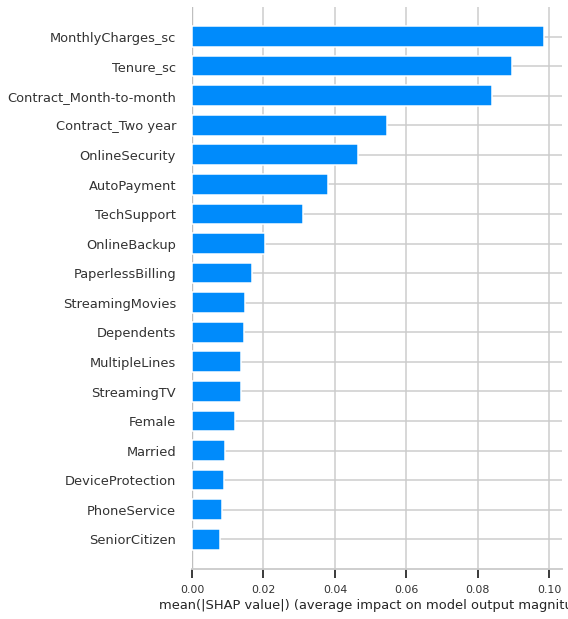

In [26]:
# Feature importance - global interpretation for all users
shap.summary_plot(shap_values_raf, X_test, plot_type="bar")

In [27]:
# Feature importance - local interpretation for one specific user
pred_raf = raf.predict(X_test)

y_test.iloc[60], pred_raf[60]
shap.initjs()
shap.force_plot(explainer_raf.expected_value[1], shap_values_raf[60, :], X_test.iloc[60, :])

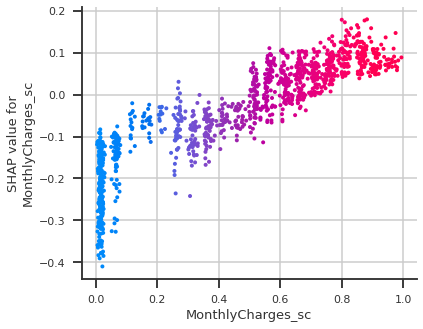

In [28]:
# Partial dependence (same feature)

shap.dependence_plot(ind="MonthlyCharges_sc", interaction_index="MonthlyCharges_sc",
                     shap_values=shap_values_raf, 
                     features=X_test,  
                     display_features=X_test)

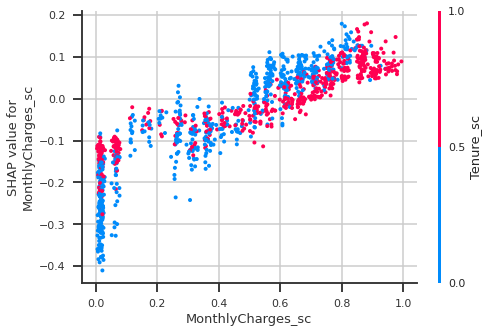

In [32]:
# Partial dependence (different features)

shap.dependence_plot(ind="MonthlyCharges_sc", interaction_index="Tenure_sc",
                     shap_values=shap_values_raf, 
                     features=X_test,  
                     display_features=X_test)

# Conclusions

  - The main features affecting churn are the monthly charges, the length of time the customer has been with the company (tenure), and the length of contract. 
  - In terms of features, the most important ones affecting churn are online security, automatic payment, and technical support.
  - The entertainment feature, such as online streaming, has less of an effect on churn compared with the security features.
  - Higher monthly charges increase churn. However, this effect is less pronounced for those customers with higher tenure (i.e., those who have been with the same company for a longer period of time). 